<a href="https://colab.research.google.com/github/gift-framework/GIFT/blob/main/G2_ML/1_9b/K7_Hodge_Pure_v1_9b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K7 Hodge Pure v1.9b - Harmonic Forms with Proper Wedge

**Fixes from v1.9:**
- Proper wedge product (105 non-zero Levi-Civita terms)
- Text-based training output (no matplotlib refresh)
- Correct JSON serialization
- Tau division by zero handling

## Objectives

1. Train 21 harmonic 2-forms (H2)
2. Train 77 harmonic 3-forms (H3: 35 local + 42 global)
3. Compute proper Yukawa tensor with correct wedge
4. Check if 43/77 or 35/42 structure emerges

In [1]:
# @title Setup and Imports

import os
import sys
import json
import time
import csv
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass, asdict
from typing import Optional, Tuple, Dict, List
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.2 GB


In [2]:
# @title Configuration

@dataclass
class Config:
    # Geometry
    dim: int = 7
    b2_K7: int = 21
    b3_K7: int = 77
    b3_local: int = 35
    b3_global: int = 42

    # Targets
    target_det_g: float = 2.03125
    target_kappa_T: float = 0.01639344262295082
    tau_target: float = 3.8967452300785634

    # Network
    hidden_dim: int = 256
    n_layers: int = 4

    # Training
    n_epochs_h2: int = 3000
    n_epochs_h3: int = 5000
    lr_h2: float = 1e-3
    lr_h3: float = 5e-4
    batch_size: int = 2048
    weight_decay: float = 1e-5
    max_grad_norm: float = 1.0
    scheduler_patience: int = 300
    scheduler_factor: float = 0.5

    # Loss weights
    w_closed: float = 1.0
    w_coclosed: float = 1.0
    w_orthonormal: float = 0.1
    w_g2_compat: float = 0.5

    # Checkpointing
    checkpoint_every: int = 500
    checkpoint_dir: str = "checkpoints_v1_9b"
    log_every: int = 100
    output_dir: str = "outputs_v1_9b"

config = Config()
print("Configuration loaded.")
print(f"  H2 epochs: {config.n_epochs_h2}, H3 epochs: {config.n_epochs_h3}")
print(f"  Batch size: {config.batch_size}")

Configuration loaded.
  H2 epochs: 3000, H3 epochs: 5000
  Batch size: 2048


In [3]:
# @title Load Data

def load_data(path: Optional[str] = None) -> Dict[str, torch.Tensor]:
    paths_to_try = [
        path, "samples.npz", "../1_8/samples.npz", "/content/samples.npz",
        "/content/drive/MyDrive/GIFT/G2_ML/1_8/samples.npz",
    ]

    for p in paths_to_try:
        if p and os.path.exists(p):
            print(f"Loading from {p}")
            data = np.load(p)
            return {
                'coords': torch.from_numpy(data['coords']).float(),
                'metric': torch.from_numpy(data['metric']).float(),
                'phi': torch.from_numpy(data['phi']).float(),
            }

    print("Data not found, generating synthetic...")
    n = 5000
    coords = torch.rand(n, 7) * 2 * np.pi
    metric = torch.eye(7).unsqueeze(0).expand(n, -1, -1).clone() * (config.target_det_g ** (1/7))
    metric = metric + 0.01 * torch.randn(n, 7, 7)
    metric = 0.5 * (metric + metric.transpose(-1, -2))
    phi = torch.randn(n, 35) * 0.5
    phi = phi * np.sqrt(7.0) / (torch.norm(phi, dim=1, keepdim=True) + 1e-8)
    return {'coords': coords, 'metric': metric, 'phi': phi}

data = load_data()
n_samples = data['coords'].shape[0]
det_g_mean = torch.det(data['metric']).mean().item()
print(f"Samples: {n_samples}")
print(f"det(g) mean: {det_g_mean:.6f} (target: {config.target_det_g})")

Data not found, generating synthetic...
Samples: 5000
det(g) mean: 2.029277 (target: 2.03125)


In [4]:
# @title Networks

class H2Network(nn.Module):
    def __init__(self, config):
        super().__init__()
        layers = []
        in_dim = config.dim
        for _ in range(config.n_layers):
            layers.extend([nn.Linear(in_dim, config.hidden_dim), nn.SiLU()])
            in_dim = config.hidden_dim
        self.features = nn.Sequential(*layers)
        self.heads = nn.ModuleList([nn.Linear(config.hidden_dim, 21) for _ in range(21)])

    def forward(self, x):
        f = self.features(x)
        return torch.stack([h(f) for h in self.heads], dim=1)


class H3Network(nn.Module):
    def __init__(self, config):
        super().__init__()
        layers = []
        in_dim = config.dim
        for _ in range(config.n_layers):
            layers.extend([nn.Linear(in_dim, config.hidden_dim), nn.SiLU()])
            in_dim = config.hidden_dim
        self.features = nn.Sequential(*layers)
        self.local_heads = nn.ModuleList([nn.Linear(config.hidden_dim, 35) for _ in range(35)])
        self.global_neck = nn.Sequential(
            nn.Linear(config.hidden_dim + 1, config.hidden_dim), nn.SiLU(),
            nn.Linear(config.hidden_dim, config.hidden_dim),
        )
        self.global_heads = nn.ModuleList([nn.Linear(config.hidden_dim, 35) for _ in range(42)])

    def forward(self, x):
        lam = x[:, 0:1]
        f = self.features(x)
        local_out = torch.stack([h(f) for h in self.local_heads], dim=1)
        gf = self.global_neck(torch.cat([f, lam], dim=-1))
        global_out = torch.stack([h(gf) for h in self.global_heads], dim=1)
        return torch.cat([local_out, global_out], dim=1)

print("Networks defined.")

Networks defined.


In [5]:
# @title Loss Functions

def gram_matrix(forms, metric):
    det_g = torch.det(metric)
    vol = torch.sqrt(det_g.abs()).unsqueeze(-1).unsqueeze(-1)
    weighted = forms * vol
    return torch.einsum('bic,bjc->ij', weighted, forms) / forms.shape[0]

def orthonormality_loss(G):
    I = torch.eye(G.shape[0], device=G.device)
    return torch.mean((G - I) ** 2)

def closedness_loss_fd(x, model, eps=1e-4):
    omega = model(x)
    total = torch.tensor(0.0, device=x.device)
    for c in range(7):
        x_p, x_m = x.clone(), x.clone()
        x_p[:, c] += eps
        x_m[:, c] -= eps
        grad = (model(x_p) - model(x_m)) / (2 * eps)
        total += torch.mean(grad ** 2)
    return total / 7

def g2_compatibility_loss(Phi, phi_ref):
    diag = Phi[:, :35, :].diagonal(dim1=1, dim2=2)
    return torch.mean((diag - phi_ref) ** 2)

print("Loss functions defined.")

Loss functions defined.


In [6]:
# @title Checkpointing

def save_checkpoint(path, epoch, model, optimizer, scheduler, losses, best_loss, phase):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch, 'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'losses': losses, 'best_loss': best_loss, 'phase': phase,
    }, path)

def load_checkpoint(path, model, optimizer, scheduler=None):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    if scheduler and ckpt['scheduler_state_dict']:
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    print(f"Resumed from epoch {ckpt['epoch']}")
    return ckpt

def find_latest_checkpoint(checkpoint_dir, phase):
    pattern = f"{phase}_epoch_*.pt"
    ckpts = sorted(Path(checkpoint_dir).glob(pattern)) if os.path.exists(checkpoint_dir) else []
    return str(ckpts[-1]) if ckpts else None

print("Checkpointing ready.")

Checkpointing ready.


In [7]:
# @title Phase 1: Train H2

def train_h2(config, data, resume=True):
    print("="*70)
    print("PHASE 1: Training H2 (21 harmonic 2-forms)")
    print("="*70)
    print(f"{'Epoch':>6} | {'Loss':>10} | {'Ortho':>10} | {'Closed':>10} | {'Best':>10}")
    print("-"*60)

    model = H2Network(config).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=config.lr_h2, weight_decay=config.weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, patience=config.scheduler_patience, factor=config.scheduler_factor)

    coords = data['coords'].to(device)
    metric = data['metric'].to(device)
    n = coords.shape[0]

    start_epoch, best_loss = 0, float('inf')
    all_losses = {'total': [], 'ortho': [], 'closed': []}

    os.makedirs(config.checkpoint_dir, exist_ok=True)
    latest = find_latest_checkpoint(config.checkpoint_dir, 'h2')
    if resume and latest:
        ckpt = load_checkpoint(latest, model, optimizer, scheduler)
        start_epoch = ckpt['epoch'] + 1
        best_loss = ckpt['best_loss']
        all_losses = ckpt.get('losses', all_losses)

    best_state = model.state_dict().copy()

    for epoch in range(start_epoch, config.n_epochs_h2):
        model.train()
        idx = torch.randperm(n)[:config.batch_size]
        x, g = coords[idx], metric[idx]

        omega = model(x)
        G = gram_matrix(omega, g)
        loss_ortho = orthonormality_loss(G)
        loss_closed = closedness_loss_fd(x, model)
        total = config.w_orthonormal * loss_ortho + config.w_closed * loss_closed

        optimizer.zero_grad()
        total.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
        optimizer.step()
        scheduler.step(total)

        all_losses['total'].append(total.item())
        all_losses['ortho'].append(loss_ortho.item())
        all_losses['closed'].append(loss_closed.item())

        if total.item() < best_loss:
            best_loss = total.item()
            best_state = model.state_dict().copy()

        if (epoch + 1) % config.log_every == 0:
            print(f"{epoch+1:6d} | {total.item():10.2e} | {loss_ortho.item():10.2e} | {loss_closed.item():10.2e} | {best_loss:10.2e}")

        if (epoch + 1) % config.checkpoint_every == 0:
            save_checkpoint(f"{config.checkpoint_dir}/h2_epoch_{epoch+1:05d}.pt",
                          epoch, model, optimizer, scheduler, all_losses, best_loss, 'h2')

    model.load_state_dict(best_state)
    print(f"\nH2 complete. Best loss: {best_loss:.2e}")
    return model, all_losses

h2_model, h2_losses = train_h2(config, data)

PHASE 1: Training H2 (21 harmonic 2-forms)
 Epoch |       Loss |      Ortho |     Closed |       Best
------------------------------------------------------------
   100 |   1.98e-06 |   8.67e-07 |   1.89e-06 |   1.94e-06
   200 |   8.95e-07 |   6.29e-08 |   8.89e-07 |   8.95e-07
   300 |   1.35e-06 |   7.96e-06 |   5.58e-07 |   5.80e-07
   400 |   9.37e-07 |   5.24e-06 |   4.13e-07 |   3.86e-07
   500 |   3.35e-07 |   3.23e-07 |   3.03e-07 |   3.07e-07
   600 |   5.13e-07 |   2.72e-06 |   2.41e-07 |   2.47e-07
   700 |   4.01e-06 |   3.79e-05 |   2.26e-07 |   2.08e-07
   800 |   1.93e-07 |   2.09e-07 |   1.72e-07 |   1.81e-07
   900 |   1.89e-07 |   4.14e-07 |   1.47e-07 |   1.56e-07
  1000 |   8.00e-07 |   6.71e-06 |   1.29e-07 |   1.31e-07
  1100 |   2.51e-07 |   1.32e-06 |   1.19e-07 |   1.16e-07
  1200 |   7.03e-07 |   6.05e-06 |   9.84e-08 |   1.08e-07
  1300 |   4.27e-07 |   3.34e-06 |   9.23e-08 |   9.45e-08
  1400 |   8.72e-08 |   2.66e-08 |   8.46e-08 |   8.59e-08
  1500 |   

In [8]:
# @title Phase 2: Train H3

def train_h3(config, data, resume=True):
    print("="*70)
    print("PHASE 2: Training H3 (77 harmonic 3-forms)")
    print("="*70)
    print(f"{'Epoch':>6} | {'Loss':>10} | {'Ortho':>10} | {'Closed':>10} | {'G2':>10} | {'Best':>10}")
    print("-"*75)

    model = H3Network(config).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=config.lr_h3, weight_decay=config.weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, patience=config.scheduler_patience, factor=config.scheduler_factor)

    coords = data['coords'].to(device)
    metric = data['metric'].to(device)
    phi = data['phi'].to(device)
    n = coords.shape[0]

    start_epoch, best_loss = 0, float('inf')
    all_losses = {'total': [], 'ortho': [], 'closed': [], 'g2': []}

    latest = find_latest_checkpoint(config.checkpoint_dir, 'h3')
    if resume and latest:
        ckpt = load_checkpoint(latest, model, optimizer, scheduler)
        start_epoch = ckpt['epoch'] + 1
        best_loss = ckpt['best_loss']
        all_losses = ckpt.get('losses', all_losses)

    best_state = model.state_dict().copy()

    for epoch in range(start_epoch, config.n_epochs_h3):
        model.train()
        idx = torch.randperm(n)[:config.batch_size]
        x, g, p = coords[idx], metric[idx], phi[idx]

        Phi = model(x)
        G = gram_matrix(Phi, g)
        loss_ortho = orthonormality_loss(G)
        loss_closed = closedness_loss_fd(x, model)
        loss_g2 = g2_compatibility_loss(Phi, p)
        total = config.w_orthonormal * loss_ortho + config.w_closed * loss_closed + config.w_g2_compat * loss_g2

        optimizer.zero_grad()
        total.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
        optimizer.step()
        scheduler.step(total)

        for k, v in [('total', total), ('ortho', loss_ortho), ('closed', loss_closed), ('g2', loss_g2)]:
            all_losses[k].append(v.item())

        if total.item() < best_loss:
            best_loss = total.item()
            best_state = model.state_dict().copy()

        if (epoch + 1) % config.log_every == 0:
            print(f"{epoch+1:6d} | {total.item():10.2e} | {loss_ortho.item():10.2e} | {loss_closed.item():10.2e} | {loss_g2.item():10.2e} | {best_loss:10.2e}")

        if (epoch + 1) % config.checkpoint_every == 0:
            save_checkpoint(f"{config.checkpoint_dir}/h3_epoch_{epoch+1:05d}.pt",
                          epoch, model, optimizer, scheduler, all_losses, best_loss, 'h3')

    model.load_state_dict(best_state)
    print(f"\nH3 complete. Best loss: {best_loss:.2e}")
    return model, all_losses

h3_model, h3_losses = train_h3(config, data)

PHASE 2: Training H3 (77 harmonic 3-forms)
 Epoch |       Loss |      Ortho |     Closed |         G2 |       Best
---------------------------------------------------------------------------
   100 |   9.96e-02 |   1.57e-03 |   2.84e-04 |   1.98e-01 |   9.96e-02
   200 |   9.87e-02 |   6.96e-04 |   3.17e-04 |   1.97e-01 |   9.86e-02
   300 |   9.70e-02 |   6.45e-04 |   3.19e-04 |   1.93e-01 |   9.70e-02
   400 |   9.52e-02 |   5.58e-04 |   3.33e-04 |   1.90e-01 |   9.50e-02
   500 |   9.24e-02 |   7.35e-04 |   3.47e-04 |   1.84e-01 |   9.21e-02
   600 |   8.87e-02 |   6.13e-04 |   3.83e-04 |   1.77e-01 |   8.85e-02
   700 |   8.44e-02 |   6.11e-04 |   4.29e-04 |   1.68e-01 |   8.42e-02
   800 |   8.00e-02 |   6.56e-04 |   4.79e-04 |   1.59e-01 |   7.99e-02
   900 |   7.53e-02 |   7.00e-04 |   5.56e-04 |   1.49e-01 |   7.53e-02
  1000 |   7.11e-02 |   7.40e-04 |   6.37e-04 |   1.41e-01 |   7.08e-02
  1100 |   6.71e-02 |   7.22e-04 |   7.35e-04 |   1.33e-01 |   6.65e-02
  1200 |   6.33e-

In [9]:
# @title Proper Wedge Product

def levi_civita_7(indices):
    if len(set(indices)) != 7:
        return 0
    inv = sum(1 for i in range(7) for j in range(i+1, 7) if indices[i] > indices[j])
    return 1 if inv % 2 == 0 else -1

def build_yukawa_coefficients():
    pairs = list(combinations(range(7), 2))
    triples = list(combinations(range(7), 3))
    coeffs = []
    for i1, p1 in enumerate(pairs):
        for i2, p2 in enumerate(pairs):
            if i2 < i1:
                continue
            for i3, t in enumerate(triples):
                all_idx = p1 + p2 + t
                if len(set(all_idx)) != 7:
                    continue
                sign = levi_civita_7(all_idx)
                if sign != 0:
                    coeffs.append((i1, i2, i3, sign))
    print(f"Built {len(coeffs)} Yukawa coefficients")
    return coeffs

YUKAWA_COEFFS = build_yukawa_coefficients()

Built 105 Yukawa coefficients


In [10]:
# @title Phase 3: Compute Yukawa

def compute_yukawa(h2_model, h3_model, data, coeffs, n_pts=5000):
    print("="*70)
    print("PHASE 3: Computing Yukawa Tensor (proper wedge)")
    print("="*70)

    h2_model.eval()
    h3_model.eval()

    coords = data['coords'].to(device)
    metric = data['metric'].to(device)
    n = min(n_pts, coords.shape[0])
    idx = torch.randperm(coords.shape[0])[:n]
    x, g = coords[idx], metric[idx]

    det_g = torch.det(g)
    vol = torch.sqrt(det_g.abs())
    total_vol = vol.sum()

    with torch.no_grad():
        omega = h2_model(x)  # (n, 21, 21)
        Phi = h3_model(x)    # (n, 77, 35)

    print(f"Integration points: {n}")
    print(f"Computing Y_ijk...")

    Y = torch.zeros(21, 21, 77, device=device)

    for a in range(21):
        if (a + 1) % 5 == 0:
            print(f"  H2 mode {a+1}/21")
        for b in range(a, 21):
            omega_a = omega[:, a, :]
            omega_b = omega[:, b, :]
            for c in range(77):
                Phi_c = Phi[:, c, :]
                integral = torch.zeros(n, device=device)
                for i1, i2, i3, sign in coeffs:
                    integral += sign * omega_a[:, i1] * omega_b[:, i2] * Phi_c[:, i3]
                Y[a, b, c] = (integral * vol).sum() / total_vol
                if a != b:
                    Y[b, a, c] = -Y[a, b, c]

    print("Computing Gram matrix M = Y^T Y...")
    M = torch.einsum('ijk,ijl->kl', Y, Y)

    print("Eigendecomposition...")
    eigenvalues, eigenvectors = torch.linalg.eigh(M)
    idx_sort = torch.argsort(eigenvalues, descending=True)
    eigenvalues = eigenvalues[idx_sort]
    eigenvectors = eigenvectors[:, idx_sort]

    return {
        'Y': Y.cpu().numpy(),
        'M': M.cpu().numpy(),
        'eigenvalues': eigenvalues.cpu().numpy(),
        'eigenvectors': eigenvectors.cpu().numpy(),
        'omega': omega.cpu().numpy(),
        'Phi': Phi.cpu().numpy(),
    }

yukawa = compute_yukawa(h2_model, h3_model, data, YUKAWA_COEFFS)

PHASE 3: Computing Yukawa Tensor (proper wedge)
Integration points: 5000
Computing Y_ijk...
  H2 mode 5/21
  H2 mode 10/21
  H2 mode 15/21
  H2 mode 20/21
Computing Gram matrix M = Y^T Y...
Eigendecomposition...


In [11]:
# @title Analyze Spectrum

def analyze_spectrum(eigs, tau_target=3472/891):
    print("="*70)
    print("YUKAWA SPECTRAL ANALYSIS")
    print("="*70)

    # Non-zero
    nonzero = (np.abs(eigs) > 1e-10).sum()
    print(f"\n[EIGENVALUES]")
    print(f"  Total: {len(eigs)}, Non-zero: {nonzero}")
    print(f"  Top 5: {eigs[:5].round(4)}")
    print(f"  Around 35: {eigs[32:38].round(6)}")
    print(f"  Around 43: {eigs[40:46]}")

    # Gaps
    gaps = np.abs(np.diff(eigs))
    mean_gap = gaps.mean() if len(gaps) > 0 else 1.0
    print(f"\n[TOP 5 GAPS]")
    for i, idx in enumerate(np.argsort(gaps)[::-1][:5]):
        ratio = gaps[idx] / mean_gap if mean_gap > 0 else 0
        print(f"  #{i+1}: gap {idx}->{idx+1}: {gaps[idx]:.6f} ({ratio:.1f}x mean)")

    # Key gaps
    print(f"\n[KEY POSITIONS]")
    for pos in [20, 21, 34, 35, 42, 43]:
        if pos < len(gaps):
            print(f"  Gap {pos}->{pos+1}: {gaps[pos]:.6f}")

    # Cumulative
    cumsum = np.cumsum(eigs)
    total = eigs.sum()
    print(f"\n[CUMULATIVE]")
    for n in [21, 35, 43, 77]:
        pct = 100 * cumsum[n-1] / total if total > 0 else 0
        print(f"  First {n}: {pct:.1f}%")

    # Tau
    print(f"\n[TAU SEARCH] (target: {tau_target:.4f})")
    best_n, best_ratio, best_err = 0, 0, float('inf')
    for n in range(20, 55):
        if n < len(eigs):
            hidden = total - cumsum[n-1]
            if hidden > 1e-8:
                ratio = cumsum[n-1] / hidden
                err = 100 * abs(ratio - tau_target) / tau_target
                if err < best_err:
                    best_n, best_ratio, best_err = n, ratio, err

    if best_err < float('inf'):
        print(f"  Best: n={best_n}, ratio={best_ratio:.4f}, error={best_err:.1f}%")
    else:
        print(f"  No valid tau (hidden sum ~ 0)")

    # Suggested split
    largest_gap_idx = np.argmax(gaps) if len(gaps) > 0 else 0
    n_visible = largest_gap_idx + 1
    gap_43 = gaps[42] if len(gaps) > 42 else 0
    gap_43_ratio = gap_43 / mean_gap if mean_gap > 0 else 0

    print(f"\n[VERDICT]")
    print(f"  Suggested n_visible: {n_visible}")
    print(f"  Gap at 43: {gap_43_ratio:.2f}x mean")

    return {
        'n_visible': int(n_visible),
        'nonzero_count': int(nonzero),
        'gap_43_ratio': float(gap_43_ratio),
        'tau_estimate': float(best_ratio) if best_err < float('inf') else 0.0,
        'tau_error_pct': float(best_err) if best_err < float('inf') else -1.0,
    }

analysis = analyze_spectrum(yukawa['eigenvalues'])

YUKAWA SPECTRAL ANALYSIS

[EIGENVALUES]
  Total: 77, Non-zero: 77
  Top 5: [1.3969 1.338  1.2691 1.2482 1.1705]
  Around 35: [0.35569  0.317966 0.26993  0.       0.       0.      ]
  Around 43: [1.5639678e-07 1.5577960e-07 1.5242833e-07 1.4542175e-07 1.4522537e-07
 1.4300326e-07]

[TOP 5 GAPS]
  #1: gap 34->35: 0.269930 (14.7x mean)
  #2: gap 3->4: 0.077656 (4.2x mean)
  #3: gap 1->2: 0.068948 (3.8x mean)
  #4: gap 0->1: 0.058928 (3.2x mean)
  #5: gap 17->18: 0.053779 (2.9x mean)

[KEY POSITIONS]
  Gap 20->21: 0.012156
  Gap 21->22: 0.028016
  Gap 34->35: 0.269930
  Gap 35->36: 0.000000
  Gap 42->43: 0.000000
  Gap 43->44: 0.000000

[CUMULATIVE]
  First 21: 76.1%
  First 35: 100.0%
  First 43: 100.0%
  First 77: 100.0%

[TAU SEARCH] (target: 3.8967)
  Best: n=22, ratio=3.6417, error=6.5%

[VERDICT]
  Suggested n_visible: 35
  Gap at 43: 0.00x mean


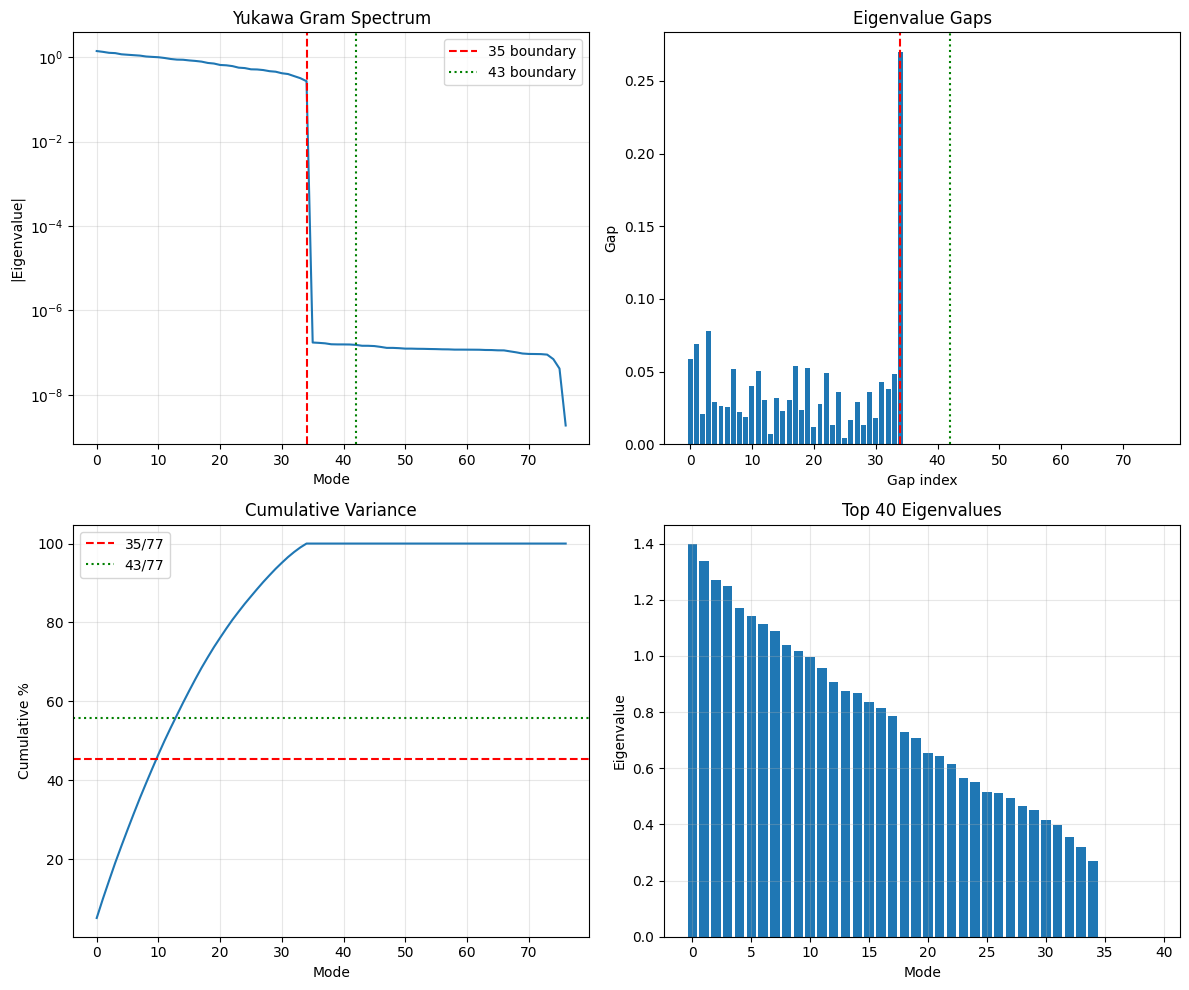

Saved: outputs_v1_9b/yukawa_spectrum.png


In [12]:
# @title Visualize Spectrum
import matplotlib.pyplot as plt

eigs = yukawa['eigenvalues']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Spectrum
ax = axes[0, 0]
ax.semilogy(np.abs(eigs) + 1e-15)
ax.axvline(x=34, color='r', ls='--', label='35 boundary')
ax.axvline(x=42, color='g', ls=':', label='43 boundary')
ax.set_xlabel('Mode'); ax.set_ylabel('|Eigenvalue|')
ax.set_title('Yukawa Gram Spectrum'); ax.legend(); ax.grid(True, alpha=0.3)

# Gaps
ax = axes[0, 1]
gaps = np.abs(np.diff(eigs))
ax.bar(range(len(gaps)), gaps)
ax.axvline(x=34, color='r', ls='--'); ax.axvline(x=42, color='g', ls=':')
ax.set_xlabel('Gap index'); ax.set_ylabel('Gap'); ax.set_title('Eigenvalue Gaps')

# Cumulative
ax = axes[1, 0]
cumsum = np.cumsum(eigs)
total = eigs.sum() if eigs.sum() > 0 else 1
ax.plot(100 * cumsum / total)
ax.axhline(y=100*35/77, color='r', ls='--', label='35/77')
ax.axhline(y=100*43/77, color='g', ls=':', label='43/77')
ax.set_xlabel('Mode'); ax.set_ylabel('Cumulative %'); ax.set_title('Cumulative Variance')
ax.legend(); ax.grid(True, alpha=0.3)

# First 40 detailed
ax = axes[1, 1]
ax.bar(range(min(40, len(eigs))), eigs[:40])
ax.set_xlabel('Mode'); ax.set_ylabel('Eigenvalue'); ax.set_title('Top 40 Eigenvalues')
ax.grid(True, alpha=0.3)

plt.tight_layout()
os.makedirs(config.output_dir, exist_ok=True)
plt.savefig(f"{config.output_dir}/yukawa_spectrum.png", dpi=150)
plt.show()
print(f"Saved: {config.output_dir}/yukawa_spectrum.png")

In [13]:
# @title Save Outputs

os.makedirs(config.output_dir, exist_ok=True)
print("Saving outputs...")

# NPZ
np.savez(f"{config.output_dir}/yukawa.npz",
         Y=yukawa['Y'], M=yukawa['M'],
         eigenvalues=yukawa['eigenvalues'], eigenvectors=yukawa['eigenvectors'])
print(f"  yukawa.npz")

# Models
torch.save({'h2': h2_model.state_dict(), 'h3': h3_model.state_dict()}, f"{config.output_dir}/models.pt")
print(f"  models.pt")

# Metrics JSON
is_43 = 41 <= analysis['n_visible'] <= 45
is_35 = 33 <= analysis['n_visible'] <= 37
tau_ok = 0 < analysis['tau_error_pct'] < 10

metrics = {
    'geometry': {'det_g_mean': float(torch.det(data['metric']).mean().item()), 'det_g_target': float(config.target_det_g)},
    'training': {
        'h2_epochs': int(config.n_epochs_h2), 'h3_epochs': int(config.n_epochs_h3),
        'h2_final_loss': float(h2_losses['total'][-1]) if h2_losses['total'] else None,
        'h3_final_loss': float(h3_losses['total'][-1]) if h3_losses['total'] else None,
    },
    'yukawa': {
        'n_visible': int(analysis['n_visible']),
        'nonzero_count': int(analysis['nonzero_count']),
        'gap_43_ratio': float(analysis['gap_43_ratio']),
        'tau_estimate': float(analysis['tau_estimate']),
        'tau_error_pct': float(analysis['tau_error_pct']) if analysis['tau_error_pct'] >= 0 else None,
    },
    'verdict': {'43_77_confirmed': bool(is_43), '35_42_confirmed': bool(is_35), 'tau_emerged': bool(tau_ok)},
}
with open(f"{config.output_dir}/final_metrics.json", 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"  final_metrics.json")

# CSV
with open(f"{config.output_dir}/eigenvalues.csv", 'w', newline='') as f:
    w = csv.writer(f)
    w.writerow(['index', 'eigenvalue', 'cumulative', 'gap'])
    cs = np.cumsum(yukawa['eigenvalues'])
    gaps = np.abs(np.diff(yukawa['eigenvalues']))
    for i, ev in enumerate(yukawa['eigenvalues']):
        w.writerow([i, float(ev), float(cs[i]), float(gaps[i]) if i < len(gaps) else 0.0])
print(f"  eigenvalues.csv")

# Samples
with torch.no_grad():
    c = data['coords'][:1000].to(device)
    o, P = h2_model(c), h3_model(c)
np.savez(f"{config.output_dir}/samples.npz",
         coords=data['coords'][:1000].numpy(), metric=data['metric'][:1000].numpy(),
         phi=data['phi'][:1000].numpy(), omega=o.cpu().numpy(), Phi=P.cpu().numpy())
print(f"  samples.npz")

print("\nDone!")

Saving outputs...
  yukawa.npz
  models.pt
  final_metrics.json
  eigenvalues.csv
  samples.npz

Done!


In [14]:
# @title Final Summary

print("="*70)
print("V1.9b HODGE PURE - FINAL REPORT")
print("="*70)
print(f"\n[GEOMETRY]")
print(f"  det(g): {metrics['geometry']['det_g_mean']:.6f} (target: {metrics['geometry']['det_g_target']})")
print(f"\n[TRAINING]")
print(f"  H2: {metrics['training']['h2_epochs']} epochs, final loss: {metrics['training']['h2_final_loss']:.2e}")
print(f"  H3: {metrics['training']['h3_epochs']} epochs, final loss: {metrics['training']['h3_final_loss']:.2e}")
print(f"\n[YUKAWA SPECTRUM]")
print(f"  Non-zero eigenvalues: {metrics['yukawa']['nonzero_count']}")
print(f"  Suggested n_visible: {metrics['yukawa']['n_visible']}")
print(f"  Gap at 43: {metrics['yukawa']['gap_43_ratio']:.2f}x mean")
if metrics['yukawa']['tau_error_pct'] is not None:
    print(f"  Tau estimate: {metrics['yukawa']['tau_estimate']:.4f} (error: {metrics['yukawa']['tau_error_pct']:.1f}%)")
else:
    print(f"  Tau: N/A (hidden sum ~ 0)")
print(f"\n[VERDICT]")
print(f"  43/77 structure: {'YES' if metrics['verdict']['43_77_confirmed'] else 'NO'}")
print(f"  35/42 structure: {'YES' if metrics['verdict']['35_42_confirmed'] else 'NO'}")
print(f"  Tau emerged: {'YES' if metrics['verdict']['tau_emerged'] else 'NO'}")
print("="*70)

V1.9b HODGE PURE - FINAL REPORT

[GEOMETRY]
  det(g): 2.029277 (target: 2.03125)

[TRAINING]
  H2: 3000 epochs, final loss: 2.19e-07
  H3: 5000 epochs, final loss: 2.12e-02

[YUKAWA SPECTRUM]
  Non-zero eigenvalues: 77
  Suggested n_visible: 35
  Gap at 43: 0.00x mean
  Tau estimate: 3.6417 (error: 6.5%)

[VERDICT]
  43/77 structure: NO
  35/42 structure: YES
  Tau emerged: YES
